# Monte Carlo ES (Exploration Starts), for estimating $\pi \approx \pi_\star$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

In [2]:
class BlackJack:
    def __init__(self, policy=None):
        self.env = gym.make('Blackjack-v1', sab=True)
        self.ACTIONS = ['STICK', 'HIT']
        self.policy = policy

    def sample(self, policy=None):
        if policy is None:
            policy = self.policy
            
        state, _ = self.env.reset()
        action = self.env.action_space.sample()
        RSA = [[0.0, state, action]]
        
        terminated = False
        while not terminated:
            state, reward, terminated, truncated, info = self.env.step(action)
            if not terminated:
                action = policy[state[0], state[1], state[2]]
            else: action = 'terminated'
                
            RSA.append([reward, state, action])

        return RSA

## Implementation of the algorithm

In [3]:
def monte_calro_ES(episodes, policy=None, Q=None, N=None, DISCOUNT=1.0):
    if policy is None or Q is None or N is None:
        policy = np.zeros((22, 11, 2), dtype=np.int32)
        Q = np.zeros((22, 11, 2, 2), dtype=np.float64)
        N = np.zeros((22, 11, 2, 2), dtype=np.int32)
    blackjack = BlackJack()

    for episode in range(episodes):
        ep = blackjack.sample(policy)
        T = len(ep)
        G = 0
        state_action_set = set()

        for t in reversed(range(T - 1)):
            reward = ep[t + 1][0]
            action = ep[t][-1]
            G = reward + DISCOUNT * G

            state = ep[t][1]
            state_action = (state[0], state[1], state[2], action)

            if state_action not in state_action_set:
                N[state_action] += 1
                Q[state_action] = Q[state_action] + (1 / N[state_action]) * (G - Q[state_action])
                policy[state_action[:-1]] = np.argmax(Q[state[0], state[1], state[2]])
        print(f'\rEpisode: {episode + 1:<6} avg: {Q.mean():>5.4e}{str(" "):>10}', end='')

    return policy, Q

In [4]:
policy = np.zeros((22, 11, 2), dtype=np.int32)
Q = np.zeros((22, 11, 2, 2), dtype=np.float64)
N = np.zeros((22, 11, 2, 2), dtype=np.int32)
policy, Q = monte_calro_ES(4_000_000, policy, Q, N)

Episode: 4000000 avg: -8.6875e-02          

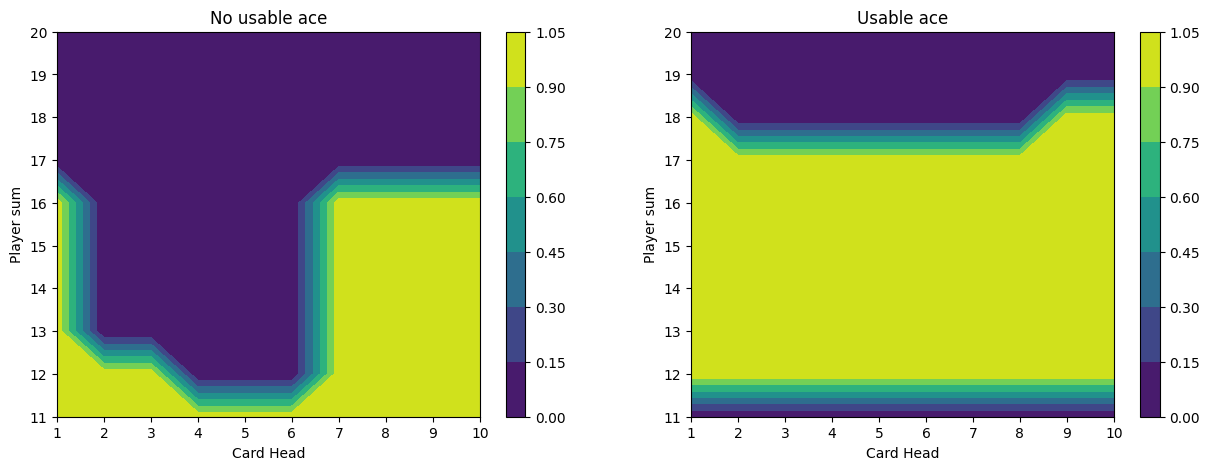

In [5]:
plt.figure(figsize=(15, 5))

xx, yy = np.meshgrid(np.arange(1, 11), np.arange(11,21))
ax = plt.subplot(1, 2, 1)
res = ax.contourf(xx, yy, policy[11:21, 1:, 0]);
ax.set_title('No usable ace');
ax.set_xlabel('Card Head');
ax.set_ylabel('Player sum');
plt.colorbar(res);

ax = plt.subplot(1, 2, 2)
res = ax.contourf(xx, yy, policy[11:21, 1:, 1]);
ax.set_title('Usable ace');
ax.set_xlabel('Card Head');
ax.set_ylabel('Player sum');
plt.colorbar(res);

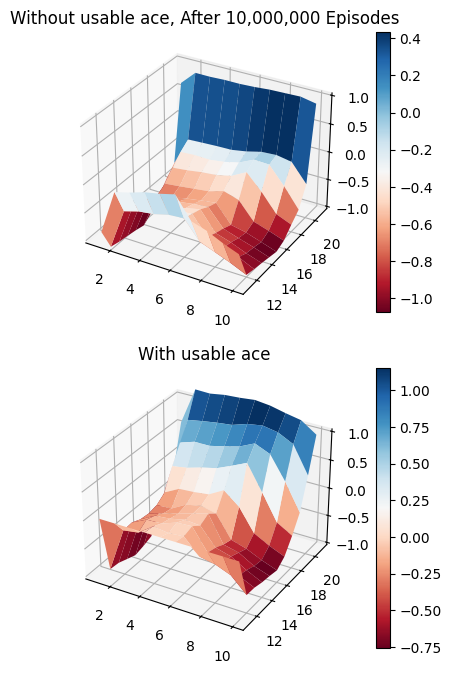

In [6]:
x, y = np.meshgrid(np.arange(1, Q.shape[1]), np.arange(11, Q.shape[0]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211, projection='3d')
surface = ax.plot_surface(x, y, Q[11:, 1:, 0].sum(axis=-1), cmap='RdBu');
ax.set_title('Without usable ace, After 10,000,000 Episodes')
ax.set_zlim((-1, 1))
plt.colorbar(surface)

ax = fig.add_subplot(212, projection='3d')
surface = ax.plot_surface(x, y, Q[11:, 1:, 1].sum(axis=-1), cmap='RdBu');
ax.set_title('With usable ace');
ax.set_zlim((-1, 1))
plt.colorbar(surface);